In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload
import os, sys, re, glob, time, pickle, IPython, logging
import scipy.ndimage as ndi
from itertools import islice
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
import torchtrainers as tt
from torch.utils.data import DataLoader
from webdataset import WebDataset
import ocrhelpers as helpers
from ocrhelpers import *
import ocrmodels as models
RUN("date"); RUN("hostname"); RUN("whoami"); RUN("nvidia-smi -L")

charset = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

def encode_str(s): 
    return [charset.find(c)+1 for c in s]

def decode_str(l): 
    return "".join([charset[k-1] for k in l])

transforms = [
    lambda x: (torch.tensor(x).float()/255.0).unsqueeze(0),
    lambda s: torch.tensor(encode_str(s)).long()
]
training = WebDataset("data/words-simple-training.tar", decoder="l8", 
                      extensions="jpg;jpeg;ppm;png txt", transforms=transforms)
testing = WebDataset("data/words-simple-test.tar", decoder="l8", 
                     extensions="jpg;jpeg;ppm;png txt", transforms=transforms)
training_dl = DataLoader(training, batch_size=5, collate_fn=helpers.collate4ocr)
testing_dl = DataLoader(testing, batch_size=20, collate_fn=helpers.collate4ocr)
next(iter(training_dl))[0].size()

date : Wed Sep 25 03:25:58 UTC 2019
hostname : tmbcomp
whoami : tmb
nvidia-smi -L : GPU 0: Tesla P4 (UUID: GPU-27d91115-5260-1301-2d09-ae7e71444af4)


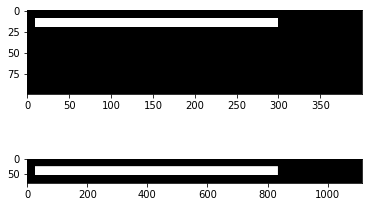

In [3]:
def compute_moments(image):
    assert amin(image) >= 0
    d0, d1 = image.shape
    c0, c1 = mgrid[0:d0, 0:d1]
    m0 = sum(c0*image) / sum(image)
    m1 = sum(c1*image) / sum(image)
    m00 = sum((c0-m0)*(c0-m0)*image) / sum(image)
    m01 = sum((c0-m0)*(c1-m1)*image) / sum(image)
    m11 = sum((c1-m1)*(c1-m1)*image) / sum(image)
    return array([m0, m1]), array([[m00, m01], [m01, m11]])

def normalize(image, height=80, r=5):
    assert amin(image) >= 0 and amax(image) <= 1
    h, w = image.shape
    (y, x), ((m00, m01), (m10, m11)) = compute_moments(image > amax(image)*0.5)
    scale = 2.0*r*(m00**.5) / height
    delta = y - scale*(height/2.0)
    result = ndi.affine_transform(image, scale*eye(2), 
                                  order=1,
                                  offset=(delta, 0), 
                                  output_shape=(height, int(w/scale)))
    assert result.shape[0] == height, result.shape
    return result

image = zeros((100, 400))
image[10:20,10:300] = 1.0
normalized = normalize(image)
subplot(211); imshow(image)
subplot(212); imshow(normalized)
#normalize(normalized);

In [4]:
transforms = [
    lambda x: torch.tensor(normalize(x/255.0)).unsqueeze(2),
    lambda s: torch.tensor(encode_str(s)).long()
]

training = WebDataset("data/words-simple-training.tar", decoder="l8", 
                      extensions="jpg;jpeg;ppm;png txt", transforms=transforms)
testing = WebDataset("data/words-simple-testing.tar", decoder="l8", 
                     extensions="jpg;jpeg;ppm;png txt", transforms=transforms)
training_dl = DataLoader(training, batch_size=5,
                         collate_fn=helpers.collate4ocr)
testing_dl = DataLoader(testing, batch_size=20,
                        collate_fn=helpers.collate4ocr)

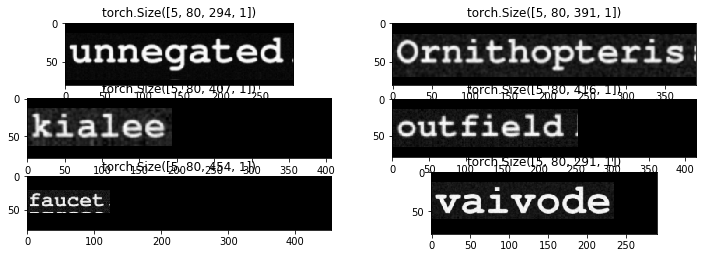

In [5]:
figsize(12, 8)
for i, sample in enumerate(islice(training_dl, 0, 60, 10)):
    subplot(6, 2, i+1)
    imshow(sample[0][0,:,:,0].detach().numpy())
    title(str(sample[0].shape))

In [6]:
!awk '/lstm_normalized/' RS="\n\n" ocrmodels.py

def make_lstm_normalized(noutput=noutput):
    model = nn.Sequential(
        layers.Input("BHWD", reorder="BDHW", range=(0, 1),
                     sizes=[None, 1, 80, None]),
        *conv2mp(50, 3, (2, 1)),
        *conv2mp(100, 3, (2, 1)),
        *conv2mp(150, 3, 2),
        layers.Reshape(0, [1, 2], 3),
        layers.Reorder("BDL", "LBD"),
        flex.LSTM(100, bidirectional=True),
        layers.Reorder("LBD", "BDL"),
        flex.Conv1d(noutput, 1),
        layers.Reorder("BDL", "BLD"))
    flex.shape_inference(model, (1, 80, 200, 1))
    return model


In [7]:
model = models.make("lstm_normalized")
model

Sequential(
  (0): Input(BHWD->BDHW torch.float32 (0, 1) cuda:0 [None, 1, 80, None])
  (1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Reshape(0, [1, 2], 3)
  (14): Reorder("BDL", "LBD")
  (15): LSTM(
    (lstm): LSTM(1500, 100, bidirectional=True

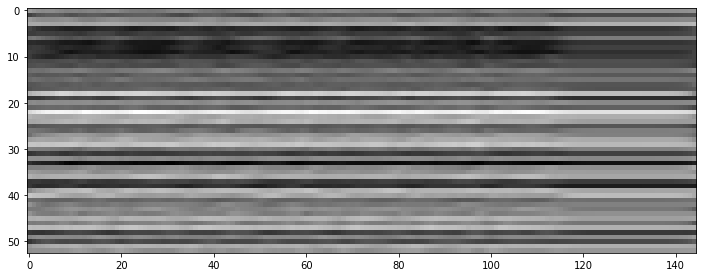

In [8]:
trainer = helpers.LineTrainer(model)
imshow(trainer.probs_batch(sample[0]).numpy()[0].T)

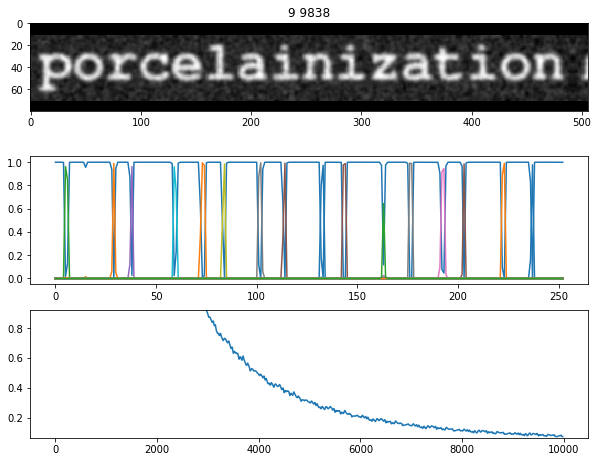

In [9]:
trainer.train(training_dl, 10, every=60)

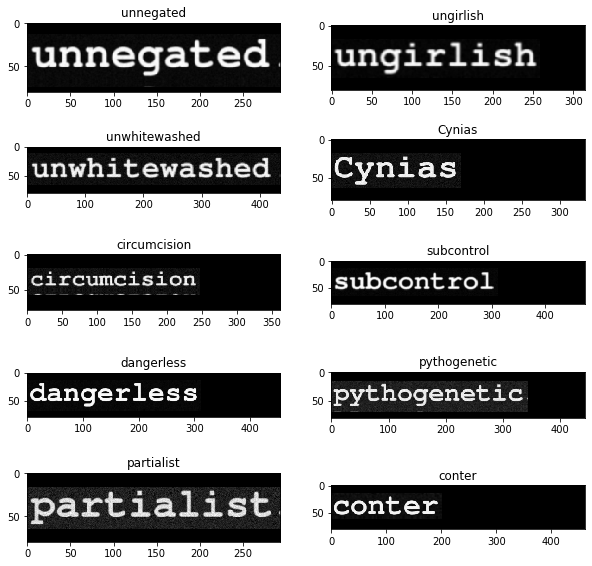

In [12]:
figsize(10, 10)
for i, batch in enumerate(islice(training_dl, 0, 10)):
    subplot(5, 2, i+1)
    result = trainer.predict_batch(*batch[:2])
    imshow(batch[0][0,:,:,0].detach().numpy())
    title(decode_str(result[0]))